# **How can the company increase its profitability by 20%**

#### **Revenue Stream**

1. **Sales fees**: Olist takes a **10%** cut on the product price (excl. freight) of each order delivered

2. **Subscription fees**: Olist charges **80 BRL** by month per seller.

#### **Costs**

1. **IT costs**
    
$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$

    cumulated IT costs = **500,000 BRL**

2. **Reputation costs**: *estimated* per order with bad reviews which takes the following values:

        1 star: 100
        2 stars: 50
        3 stars: 40
        4 stars: 0
        5 stars: 0

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.api import graphics

In [2]:
from olist.seller_updated_solution import Seller

#creating an instance for the Class
seller = Seller()

#getting the dataframe for sellers
sellers = seller.get_training_data()

### **How does the review costs affect company profits?**
- Olist profits and review costs have a inverse relationship. 

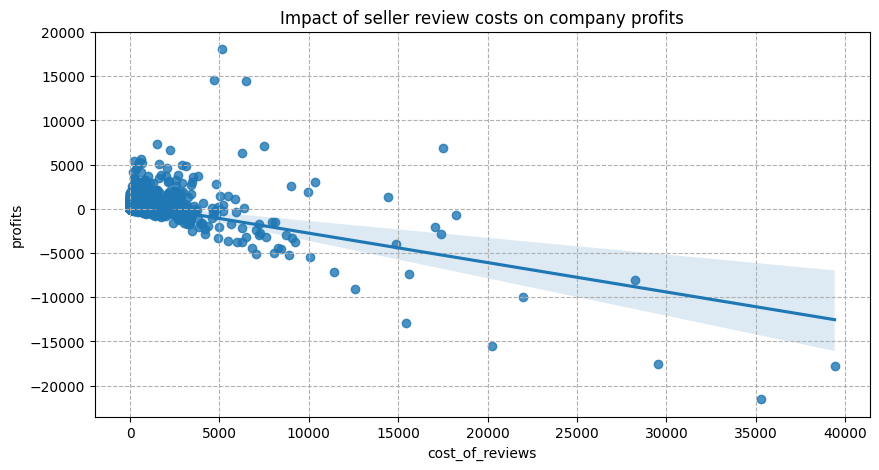

In [3]:
plt.figure(figsize=(10, 5))
sns.regplot(data=sellers, x='cost_of_reviews', y='profits',ci=95)
plt.title('Impact of seller review costs on company profits')

plt.grid(linestyle='--')
plt.show()

## **Removing an optimal number of underperforming sellers**
- to have a more efficient seller base while cutting on IT cost.
- to increase brand and buyer trust.

In [4]:
#sorting the sellers based on company profits per seller
sorted_sellers = sellers.sort_values(by='profits',ascending=False)

#method to get the updated IT cost
def it_cost(sorted_sellers):
    total_sellers = sellers['seller_id'].nunique()
    total_products =  sellers['quantity'].sum()
    n_sellers = sorted_sellers['seller_id'].nunique()
    n_product = sorted_sellers['quantity'].sum()
    
    accumulate_cost = 500000
    a = 3157.27
    b = 978.23
    updated_cost = accumulate_cost - ((a*((total_sellers - n_sellers)**0.5)) + (b*(total_products - n_product)**0.5))
    return updated_cost

#method to get key financial information
def olist_financials(sorted_sellers):
    
    updated_revenue = sorted_sellers['revenues'].sum()
    gross_profits = sorted_sellers['profits'].sum()
    system_cost = it_cost(sorted_sellers)
    review_cost = sorted_sellers['cost_of_reviews'].sum()
    
    #computing for gross profit margin
    gpm = (gross_profits/updated_revenue)*100
    
    #computing for the net profit
    np = gross_profits - system_cost
    
    #computing for the net profit margin
    npm = (np/updated_revenue)*100
    
    
    #dictionary to see the financials of the company
    
    financials={'revenue':updated_revenue, 'it_cost': system_cost, 'gross_profit': gross_profits, 'gross_profit_margin': gpm,'net_profit': np, 'net_profit_margin': npm,}

    return financials

#method to remove underperforming sellers
def remove_sellers(sorted_sellers, n):
    updated_sellers = sorted_sellers.drop(sorted_sellers.tail(n).index)
    return olist_financials(updated_sellers)

In [5]:
#Applying what-if analysis
interval = np.arange(0,1220, 20)

def finacials_df(interval, sorted_sellers):
    data = {}
    for n in interval:
        data[n] = remove_sellers(sorted_sellers, n)
    return data

data = finacials_df(interval, sorted_sellers)

#creating the dataframe
df = pd.DataFrame.from_dict(data, orient='index').reset_index().round(decimals=2)
df = df.rename(columns={'index': 'n_sellers_removed'})

#### **IT costs are reduced by 50% when 200 - 400 sellers are removed**

In [6]:
conditions = [0,100,200,300,400,500,600,700,800,900,1000]
filtered_df = df[df['n_sellers_removed'].isin(conditions)]

df1 = filtered_df[['n_sellers_removed', 'revenue', 'it_cost']]
df1.style.format("{:,.0f}")

,n_sellers_removed,revenue,it_cost
0,0,"2,785,818","500,000"
5,100,"2,430,356","278,386"
10,200,"2,341,666","251,422"
15,300,"2,324,256","239,015"
20,400,"2,310,912","228,974"
25,500,"2,309,354","221,158"
30,600,"2,307,209","214,050"
35,700,"2,302,551","207,329"
40,800,"2,297,374","200,979"
45,900,"2,275,224","193,295"


##### **We have the following trends for costs and revenues:**

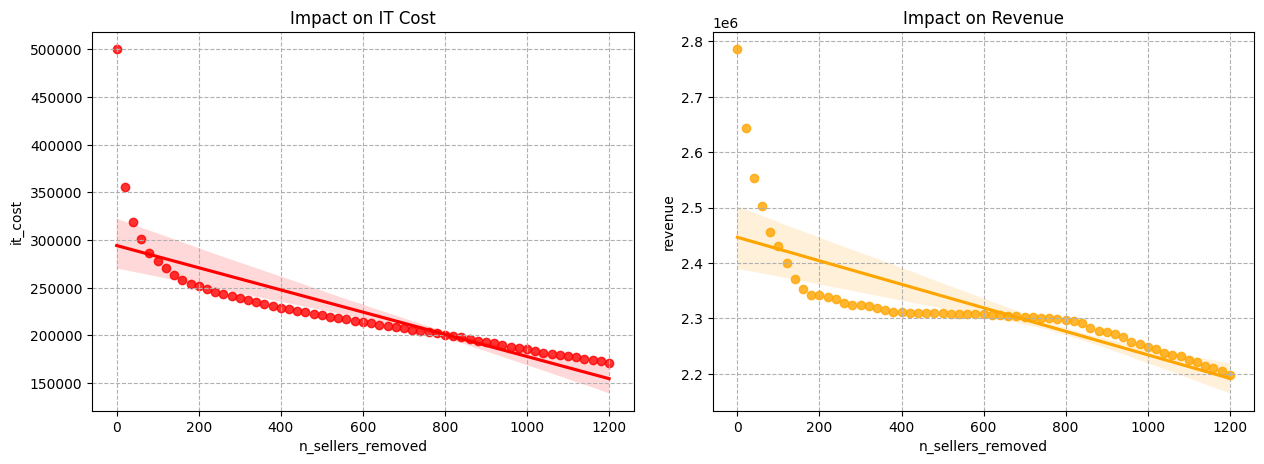

In [7]:
fig, ax = plt.subplots(ncols=2, squeeze=True, figsize=(13, 5))
sns.regplot(data=df, x='n_sellers_removed', y='it_cost', color='red', ax=ax[0])
sns.regplot(data=df, x='n_sellers_removed', y='revenue', color='orange', ax=ax[1])

ax[0].set_title('Impact on IT Cost')
ax[1].set_title('Impact on Revenue')

ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')

fig.tight_layout(pad=2.0)

plt.show()


On an assumption that:

    gross profit = revenue - accumulated cost of reviews/seller

In [8]:
df1 = filtered_df[['n_sellers_removed', 'gross_profit', 'net_profit']]
df1.style.format("{:,.0f}")

,n_sellers_removed,gross_profit,net_profit
0,0,"1,167,608","667,608"
5,100,"1,447,666","1,169,280"
10,200,"1,466,586","1,215,164"
15,300,"1,472,836","1,233,821"
20,400,"1,474,042","1,245,067"
25,500,"1,473,684","1,252,526"
30,600,"1,472,899","1,258,850"
35,700,"1,471,541","1,264,212"
40,800,"1,469,194","1,268,215"
45,900,"1,464,434","1,271,139"


##### **We have the following trends for profits:**

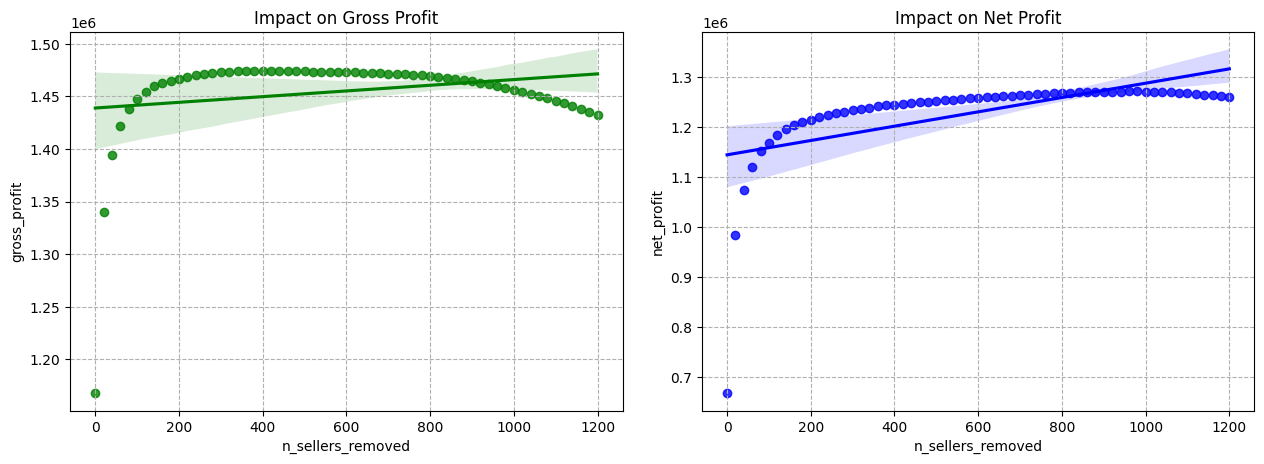

In [9]:
fig, ax = plt.subplots(ncols=2, squeeze=True, figsize=(13, 5))
sns.regplot(data=df, x='n_sellers_removed', y='gross_profit', color='green', ax=ax[0])
sns.regplot(data=df, x='n_sellers_removed', y='net_profit', color='blue', ax=ax[1])

ax[0].set_title('Impact on Gross Profit')
ax[1].set_title('Impact on Net Profit')

ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')

fig.tight_layout(pad=2.0)

plt.show()

### **How is the company's profitability?**

The number of sellers to remove and both net and gross profit margins have a proportional relationship.

In [10]:
df2 = filtered_df[['n_sellers_removed','gross_profit_margin', 'net_profit_margin']]
df2['gross_profit_margin'] = df2['gross_profit_margin'].apply( lambda x : str(x) + '%')
df2['net_profit_margin'] = df2['net_profit_margin'].apply( lambda x : str(x) + '%')
df2

,n_sellers_removed,gross_profit_margin,net_profit_margin
0,0,41.91%,23.96%
5,100,59.57%,48.11%
10,200,62.63%,51.89%
15,300,63.37%,53.08%
20,400,63.79%,53.88%
25,500,63.81%,54.24%
30,600,63.84%,54.56%
35,700,63.91%,54.9%
40,800,63.95%,55.2%
45,900,64.36%,55.87%


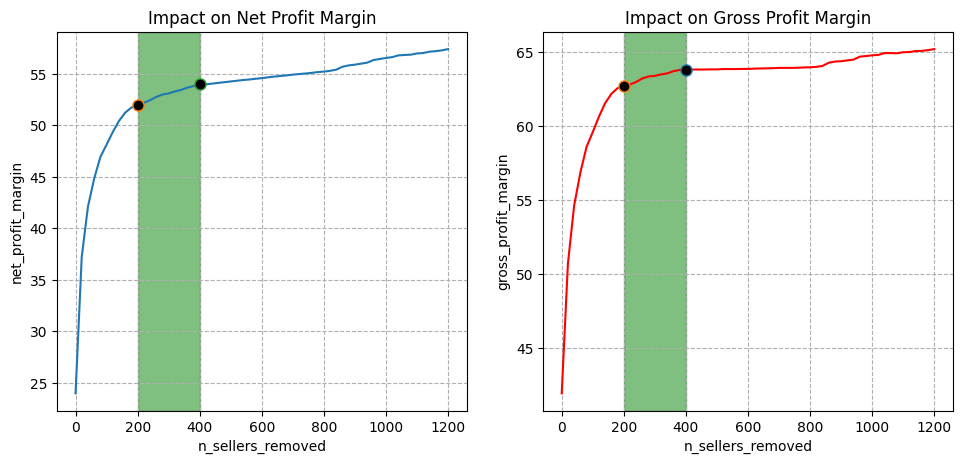

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=2, squeeze=True, figsize=(10,5))
sns.lineplot(data=df, x='n_sellers_removed', y='net_profit_margin', ax=ax[0])
sns.lineplot(data=df, x='n_sellers_removed', y='gross_profit_margin', color='red',ax=ax[1])

ax[0].set_title('Impact on Net Profit Margin')
ax[1].set_title('Impact on Gross Profit Margin')

ax[0].grid(linestyle='--')
ax[0].axvspan(200, 400, color='green', alpha=0.5)
ax[1].grid(linestyle='--')
ax[1].axvspan(200, 400, color='green', alpha=0.5)

ax[0].plot(200, 52, marker='o', markersize=8, markerfacecolor='black')
ax[0].plot(400, 54, marker='o', markersize=8, markerfacecolor='black')

ax[1].plot(400, 63.8, marker='o', markersize=8, markerfacecolor='black')
ax[1].plot(200, 62.7, marker='o', markersize=8, markerfacecolor='black')

fig.tight_layout(pad=2.0)

plt.show()

## **How do we determine the optimal number of sellers to remove?**
Using an ols model to check the relationship between the number of removed sellers relative to:
- Net profit margin
- IT cost 
- Net profit 
- Revenue

In [12]:
std_df = (df - df.mean())/df.std()

features = ['net_profit_margin', 'net_profit', 'it_cost', 'revenue']
features_df = std_df[features] 

features_df['n_sellers_removed'] = df['n_sellers_removed']

model = smf.ols(formula ='n_sellers_removed ~ net_profit_margin + net_profit + it_cost + revenue',data=features_df).fit()

Text(0.5, 0, 'number of sellers to remove')

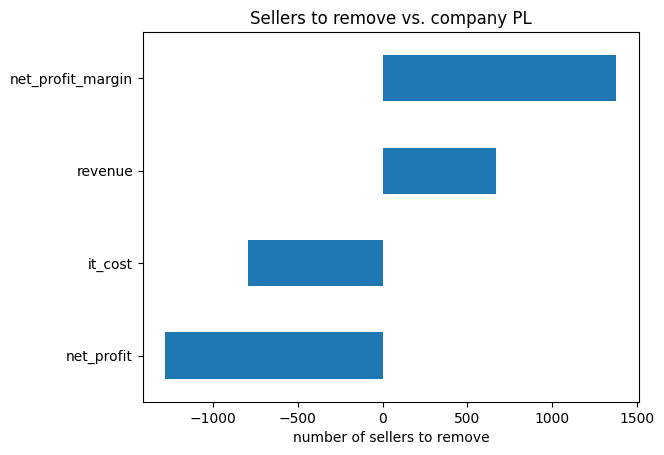

In [13]:
model.params[1:].sort_values().plot(kind='barh')
plt.title('Sellers to remove vs. company PL')
plt.xlabel('number of sellers to remove')

In [14]:
model.rsquared

0.9951565321816198

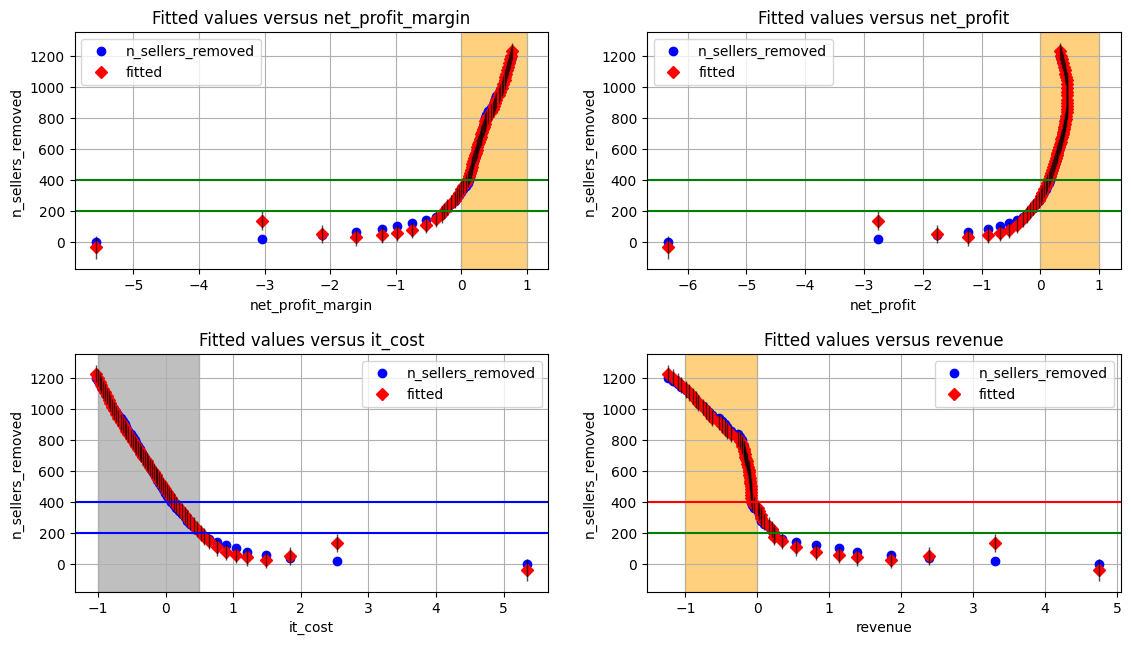

In [15]:
x= 'n_sellers_removed'
y1 = 'net_profit_margin'
y2 = 'net_profit'
y3 = 'it_cost'
y4 = 'revenue'

fig, ax = plt.subplots(nrows=2, ncols=2, squeeze=True, figsize=(12, 7))
fig.tight_layout(pad=4.0)

graphics.plot_fit(results=model, exog_idx=y1, ax=ax[0,0])
graphics.plot_fit(results=model, exog_idx=y2, ax=ax[0,1])
graphics.plot_fit(results=model, exog_idx=y3, ax=ax[1,0])
graphics.plot_fit(results=model, exog_idx=y4, ax=ax[1,1])

ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()

ax[0,0].axvspan(0,1, color='orange', alpha=0.5)
ax[0,0].axhline(y=400, color='green')
ax[0,0].axhline(y=200, color='green')

ax[0,1].axvspan(0,1, color='orange', alpha=0.5)
ax[0,1].axhline(y=400, color='green')
ax[0,1].axhline(y=200, color='green')

ax[1,0].axvspan(-1,0.5, color='gray', alpha=0.5)
ax[1,0].axhline(y=400, color='blue')
ax[1,0].axhline(y=200, color='blue')

ax[1,1].axvspan(-1, 0, color='orange', alpha=0.5)
ax[1,1].axhline(y=400, color='red')
ax[1,1].axhline(y=200, color='green')

plt.show()


##### Positive impacts
> As the number of sellers to remove increases, the **IT cost decreases** which **increases the net profit** resulting to **higher net profit margin**.

##### Trade-off
> As the number of sellers to remove increases, the revenue starts to gradually decrease. However, the **significant drop in revenue** will start when the number of sellers removed goes **beyond 400**. 

## Conclusion

The fastest way to increase profit is to cut the costs. However, the optimal number to remove should only be within the range of **200 - 400 sellers** to avoid a significant decrease in overall revenue while still maintaining a fairly high profitability of **50%**.

Removing more than the suggested number would result in a **substantial decrease in revenue**. 

### Recommendation:
Establishing a **quarterly threshold for accumulated seller review costs** and impplementing a **penalty fee** if they pass the maximum amount. 